# librayies

In [103]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import pmdarima as pm
from pmdarima.datasets.stocks import load_msft
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape
from sktime.utils.plotting import plot_series
print(f"Using pmdarima {pm.__version__}")

import warnings
warnings.filterwarnings("ignore")

Using pmdarima 1.8.5


# data

In [88]:
df = load_msft()
print(f"df.shape: {df.shape}\n")
df.head()

df.shape: (7983, 7)



,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0


# data split

In [140]:
# training and test data
train_data, test_data = df[0:int(len(df) * 0.8)], df[int(len(df) * 0.8):]
print(f"train data shape: {train_data.shape}")
print(f"test data shape: {test_data.shape}")

# open series
y_train = train_data["Open"].values
y_test = test_data["Open"].values

train data shape: (6386, 7)
test data shape: (1597, 7)


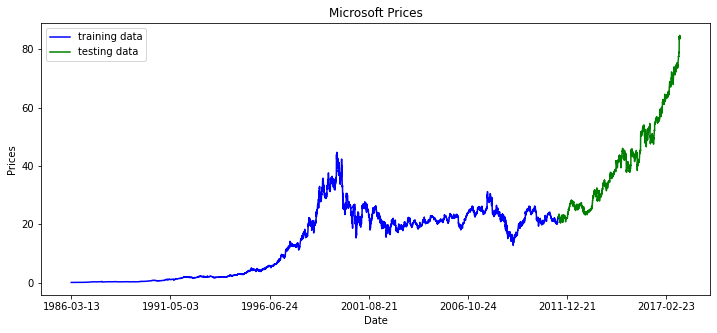

In [144]:
plt.figure(figsize = (12, 5))
plt.plot(train_data["Open"], c = "blue", label = "training data")
plt.plot(test_data["Open"], c = "green", label = "testing data")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.xticks(np.arange(0, 7982, 1300), df["Date"][0:7928:1300])
plt.legend()
plt.title("Microsoft Prices")
plt.show();

# ARIMA

## 自相关图

Text(0.5, 1.0, 'Microsoft Autocorrelation plot')

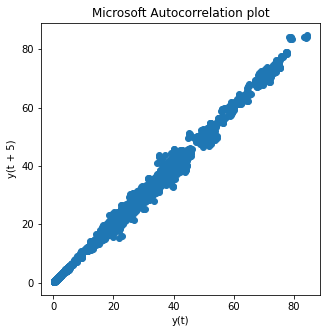

In [48]:
plt.figure(figsize = (5, 5))
lag_plot(df["Open"], lag = 5)
plt.title("Microsoft Autocorrelation plot")

## 模型训练

In [145]:
history = [x for x in y_train]
predictions = []
for t in range(len(y_test)):
    model = ARIMA(history, order = (5, 1, 0))
    model_fit = model.fit()
    y_pred = model_fit.predict()
    predictions.append(y_pred[0])
    history.append(y_test[t])
mse = mean_squared_error(test_ar, predictions)
print("Testing MSE: %.3f" % mse)

smape = smape(test_ar, predictions)
print("Testing SMAPE: %.3f" % smape)

Testing MSE: 1951.822
Testing SMAPE: 200.000


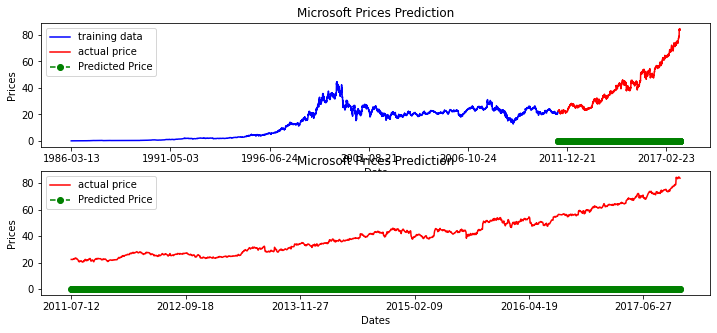

In [148]:
fig, axes = plt.subplots(2, 1, figsize = (12, 5))

# actual vs predicted
axes[0].plot(train_data["Open"], c = "blue", label = "training data")
axes[0].plot(test_data["Open"], c = "red", label = "actual price")
axes[0].plot(
    test_data.index, predictions, 
    c = "green", marker = "o", linestyle = "dashed", 
    label = "Predicted Price"
)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Prices")
axes[0].set_xticks(np.arange(0, 7982, 1300), df["Date"][0:7928:1300])
axes[0].set_title("Microsoft Prices Prediction")
axes[0].legend()

# actual vs prediction
axes[1].plot(test_data['Open'], c = 'red', label = 'actual price')
axes[1].plot(
    test_data.index, predictions, 
    c = 'green', marker = 'o', linestyle = 'dashed',
    label = 'Predicted Price'
)
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')
axes[1].set_xticks(np.arange(6386,7982, 300), df['Date'][6386:7982:300])
axes[1].set_title('Microsoft Prices Prediction')
axes[1].legend()

# auto-ARIMA

## 自相关图

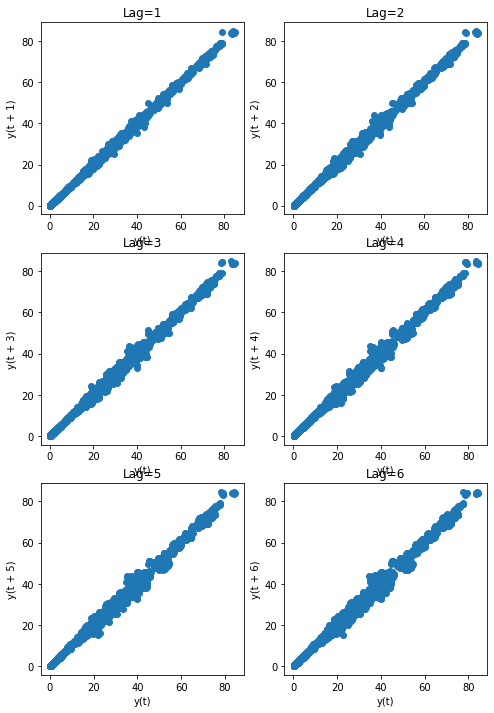

In [91]:
# 自相关图
num_row, num_column = 3, 2
fig, axes = plt.subplots(num_row, num_column, figsize = (8, 12))
plt.title("MSFT Autocorrelation plot")
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]
for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df["Open"], lag = lag, ax = axis)
    axis.set_title(f"Lag={lag}")
plt.show()

## 估计差分度

In [92]:
kpss_diffs = ndiffs(y_train, alpha = 0.05, test = 'kpss', max_d = 6)
adf_diffs = ndiffs(y_train, alpha = 0.05, test = "adf", max_d = 6)
n_diffs = max(kpss_diffs, adf_diffs)
print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


## 模型训练

In [146]:
auto = pm.auto_arima(
    y_train,
    d = n_diffs,
    seasonal = False,
    stepwise = True,
    suppress_warnings = True,
    error_action = "ignore",
    max_p = 6,
    max_order = None,
    trace = True
)
print(f"auto arima order: {auto.order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5642.904, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5640.878, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5640.426, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5640.350, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5639.441, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5640.152, Time=2.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.990 seconds
auto arima order: (0, 1, 0)


## 更新模型

In [108]:
model = auto
def forecast_one_step():
    fc, conf_int = model.predict(n_periods = 1, return_conf_int = True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

forecasts = []
confidence_intervals = []
for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    model.update(new_ob)

print(f"MSE: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

MSE: 0.34238951346274255
SMAPE: 0.9825490519101437


## 查看预测结果

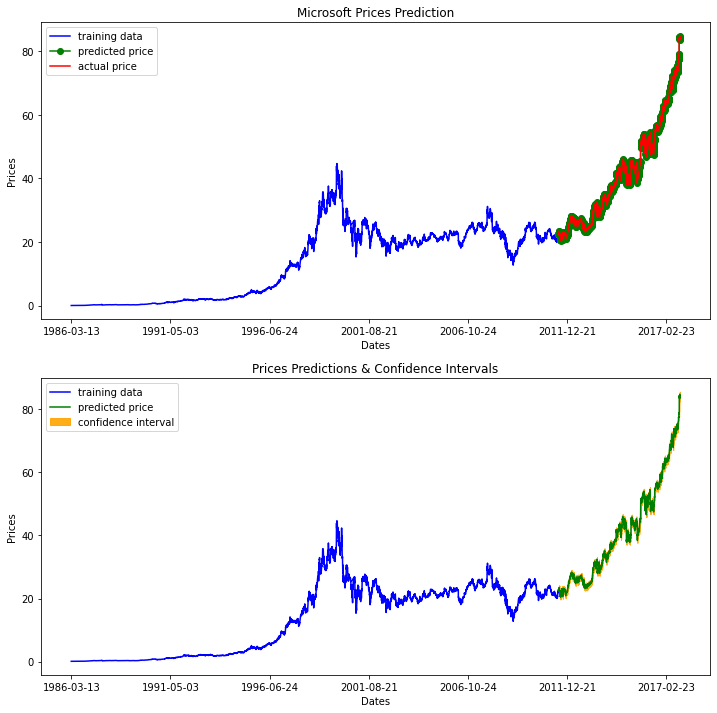

In [137]:
fig, axes = plt.subplots(2, 1, figsize = (12, 12))

# actual vs. predicted
axes[0].plot(y_train, c = "blue", label = "training data")
axes[0].plot(test_data.index, forecasts, c = "green", marker = "o", label = "predicted price")
axes[0].plot(test_data.index, y_test, c = "red", label = "actual price")
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')
axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()

# predicted with confidence intervals
axes[1].plot(y_train, c = "blue", label = "training data")
axes[1].plot(test_data.index, forecasts, c = "green", label = "predicted price")
conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(
    test_data.index, conf_int[:, 0], conf_int[:, 1], 
    alpha = 0.9, 
    color = "orange", 
    label = "confidence interval"
)
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')
axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].legend()

plt.show()